In [107]:
#!pip install nmrglue
#tojdx "C:\Users\donny\Desktop\desktop_files\Brown\exportedSERdata\name_data.dx" 0 0 * * *     (to save bruker output fid)
#   tojdx "C:\Users\donny\Desktop\desktop_files\Brown\exportedSERdata\QT_TEST1.dx" 2 * * * *      (to save bruker outputed spectrum)
#plt.rcParams["font.family"] = "Helvetica"
#%config InlineBackend.figure_format='svg'

import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import nmrglue as ng
import pulsee.plot as vis
import operators as op
import global_constants as glob
import tomography_helper_functions as helper
from coeff_groups_class import CoefficientGroups, clean_dm
from statistics import median
import matplotlib as mpl
import pandas as pd
from matplotlib.ticker import MaxNLocator
# import pulsee.simulation as sim

# commented out cuz it causes my computer to not plot anything:
#%matplotlib notebook

#B_0 = 14.0921  # Tesla
#J = 22.22  # Hz
#L_FREQ = -J / 2
#R_FREQ = J / 2

# probably won't need...?
#SPECTRUM_OFFSET = 49697.66
#w_1_Bruker = 242950699.7  # Hz
#w_2_Bruker = 242951648.8  # Hz
#TEMP = 310  # Kelvin
plt.rcParams['figure.dpi'] = glob.DPI_DISPLAY


""" This is to save plots as PDF with editable text (so that Adobe illustrator recognizes text) """
plt.rcParams['font.family'] = ['Helvetica']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [108]:
def new_hz_to_ppm(x):  #transform
    return ((x - BF1) / BF1) * 1e6


def new_ppm_to_hz(x):  #inverse transform
    return (x * BF1 / 1e6) + BF1

In [109]:
AQ = 1  #AQ [sec]
SWH = 6250  #Spectral Width in Hertz
BF1 = 202.4765753e6  #BF1 is the basic transmitter frequency. Effectively it is the reference freq. (Levitt pg. 53)
SFO1 = 202.4752106e6  #SFO1 is the transmitter frequency
SF = 202.4765753e6  #SF is interpreted by display and plot routines for generating the axis (scale) calibration in Bruker (Bruker data graphs SF as the center). Ideally this SF=BF1, as this is the convention in our paper. 
#But there is some nuance here, SF may need to be set to SFO1 to see relevant data in Bruker at a small window size?? Maybe not tho, I need to test this. But SF=BF1 is what we are generally are defining PPM axis off of.

In [110]:
#Need to navigate to folder containg folder "pdata"
Bruker_folders_path = r"C:\Users\donny\Desktop\desktop_files\Brown\All_data\Tomography_data\2024_02_14\2024_02_14\Other\4"
Bruker_folders_path = r"C:\Users\donny\Desktop\desktop_files\Brown\All_data\Final_Organized_MIT_DATA\2024_12_23-24\NOT_TOMOGRAPHY\Spectrum\113"
Bruker_folders_path_pdata_1=f"{Bruker_folders_path}/pdata/1"
p1_folder_nums = os.listdir(Bruker_folders_path)
p1_folder_nums
#Bruker_folders_path_pdata_1= os.listdir(Bruker_folders_path_pdata_1)
#Bruker_folders_path_pdata_1

['acqu',
 'acqus',
 'adcInfo_TRX2.xml',
 'audita.txt',
 'fid',
 'format.temp',
 'pdata',
 'pulseprogram',
 'scon2',
 'shimvalues',
 'specpar',
 'uxnmr.info',
 'uxnmr.par',
 'vtc_pid_settings']

In [111]:
all_data = ng.bruker.read_pdata(Bruker_folders_path_pdata_1, all_components=True)[1] # all_components=True to get both the real & imaginary spectra
all_data = np.array(all_data)
print(all_data)

[[ 21999232.  53773440.  60378752. ... -37238528. -20849792.   4937728.]
 [ 34810752.  11072512. -35233408. ...   9945728.  26451456.  33298816.]]


In [112]:
#Auto Phase Data
complex_data = np.array(all_data[0] + 1j * all_data[1])
fixed=ng.process.proc_autophase.autops(complex_data, "acme", p0=0.0, p1=0.0)
#plt.plot(np.linspace(0,1,len(phased_data_real)),fixed)
real_part = np.real(fixed)
imaginary_part = np.imag(fixed)

Optimization terminated successfully.
         Current function value: 37693565.210844
         Iterations: 98
         Function evaluations: 183


In [113]:
#inputList[1][0]
array1r = all_data[0]
array1i = all_data[1]
column_values = ['Imaginary']
df = pd.DataFrame(data=array1i, columns=column_values)
df.insert(0, "Real", array1r)
real_spectrum = df["Real"]

SFO1_centered_x_axis = np.linspace(SFO1 + SWH / 2, SFO1 - SWH / 2, len(real_spectrum))  #SFO1 is center of spectrum
SF_centered_x_axis = np.linspace(SF + SWH / 2, SF - SWH / 2, len(real_spectrum))  #SF is center of spectrum
BF1_centered_x_axis = np.linspace(BF1 + SWH / 2, BF1 - SWH / 2, len(real_spectrum))  #BF1 is center of spectrum

#We want to form an x-axis where these are centered at 0
SFO1_centered_x_axis_recentered = SFO1_centered_x_axis - median(SFO1_centered_x_axis)
SF_centered_x_axis_recentered = SFO1_centered_x_axis_recentered - (median(SF_centered_x_axis) - median(SFO1_centered_x_axis))  #SF is centered, this is how Bruker graphs data
BF1_centered_x_axis_recentered = SFO1_centered_x_axis_recentered - (median(BF1_centered_x_axis) - median(SFO1_centered_x_axis))  #Data centered with BF1=0, This is how we will do it in the paper

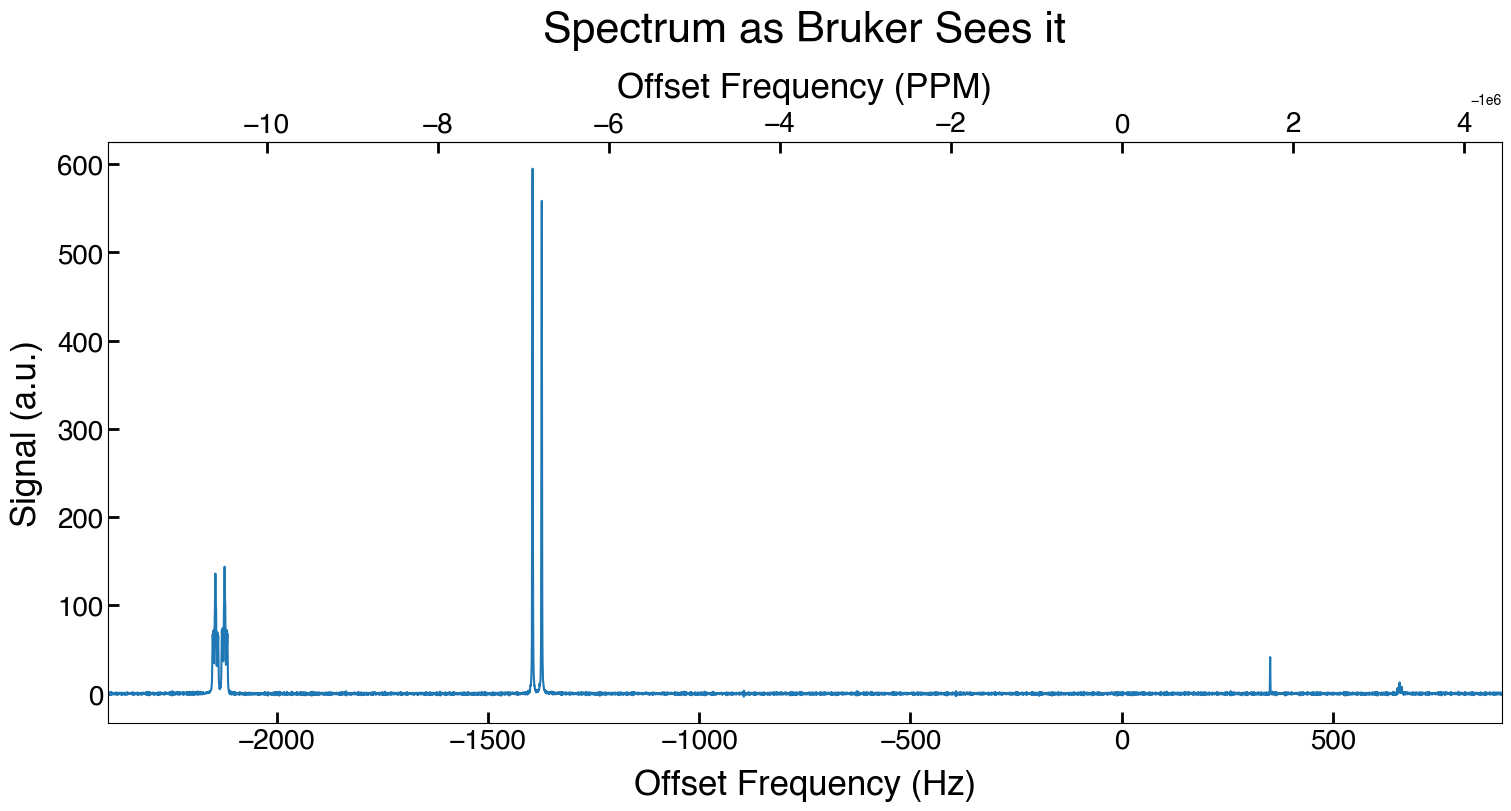

In [114]:
fig, ax = plt.subplots(constrained_layout=True)
mpl.rcParams['figure.dpi'] = 600

ax.plot(SF_centered_x_axis_recentered, real_spectrum / 10 ** 8 )
ax.set_xlabel('Offset Frequency (Hz)', size=25, labelpad=10)
ax.set_ylabel('Signal (a.u.)', size=25, labelpad=10)
ax.set_title('Spectrum as Bruker Sees it', size=31, pad=22)
secax = ax.secondary_xaxis('top', functions=(new_hz_to_ppm, new_ppm_to_hz))
secax.set_xlabel('Offset Frequency (PPM)', size=25, color='black', labelpad=10)

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.xaxis.label.set_color('black')

secax.tick_params(direction='in', axis='x', colors='black', labelsize=20)
ax.tick_params(direction='in', axis='x', colors='black', labelsize=20)
ax.tick_params(direction='in', axis='y', colors='black', labelsize=20)

#ax.fill_between(SF_centered_x_axis_recentered, real_spectrum/10**8, color='#334c80')
#ax.fill_between(SF_centered_x_axis_recentered, real_spectrum/10**8, where = SF_centered_x_axis_recentered>-1000, color='#759ebc') 


#plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0), useOffset=+2.4295e8)
ax.xaxis.get_offset_text().set_fontsize(16)
ax.xaxis.set_tick_params(size=8, width=2)
ax.yaxis.set_tick_params(size=8, width=2)
secax.xaxis.set_tick_params(size=8, width=2)
#Force the y-axis ticks to use 1e-9 as a base exponent 
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.1f')%(x*1e-8)))


plt.xlim(median(SF_centered_x_axis_recentered) + SWH / 2, median(SF_centered_x_axis_recentered) - SWH / 2)
plt.xlim(-2400, 900)
#plt.ylim(-.1 , 4)
fig.set_figheight(8)
fig.set_figwidth(15)
plt.savefig('ADP-BRUKER-VIEW.pdf', format='pdf')
plt.show()

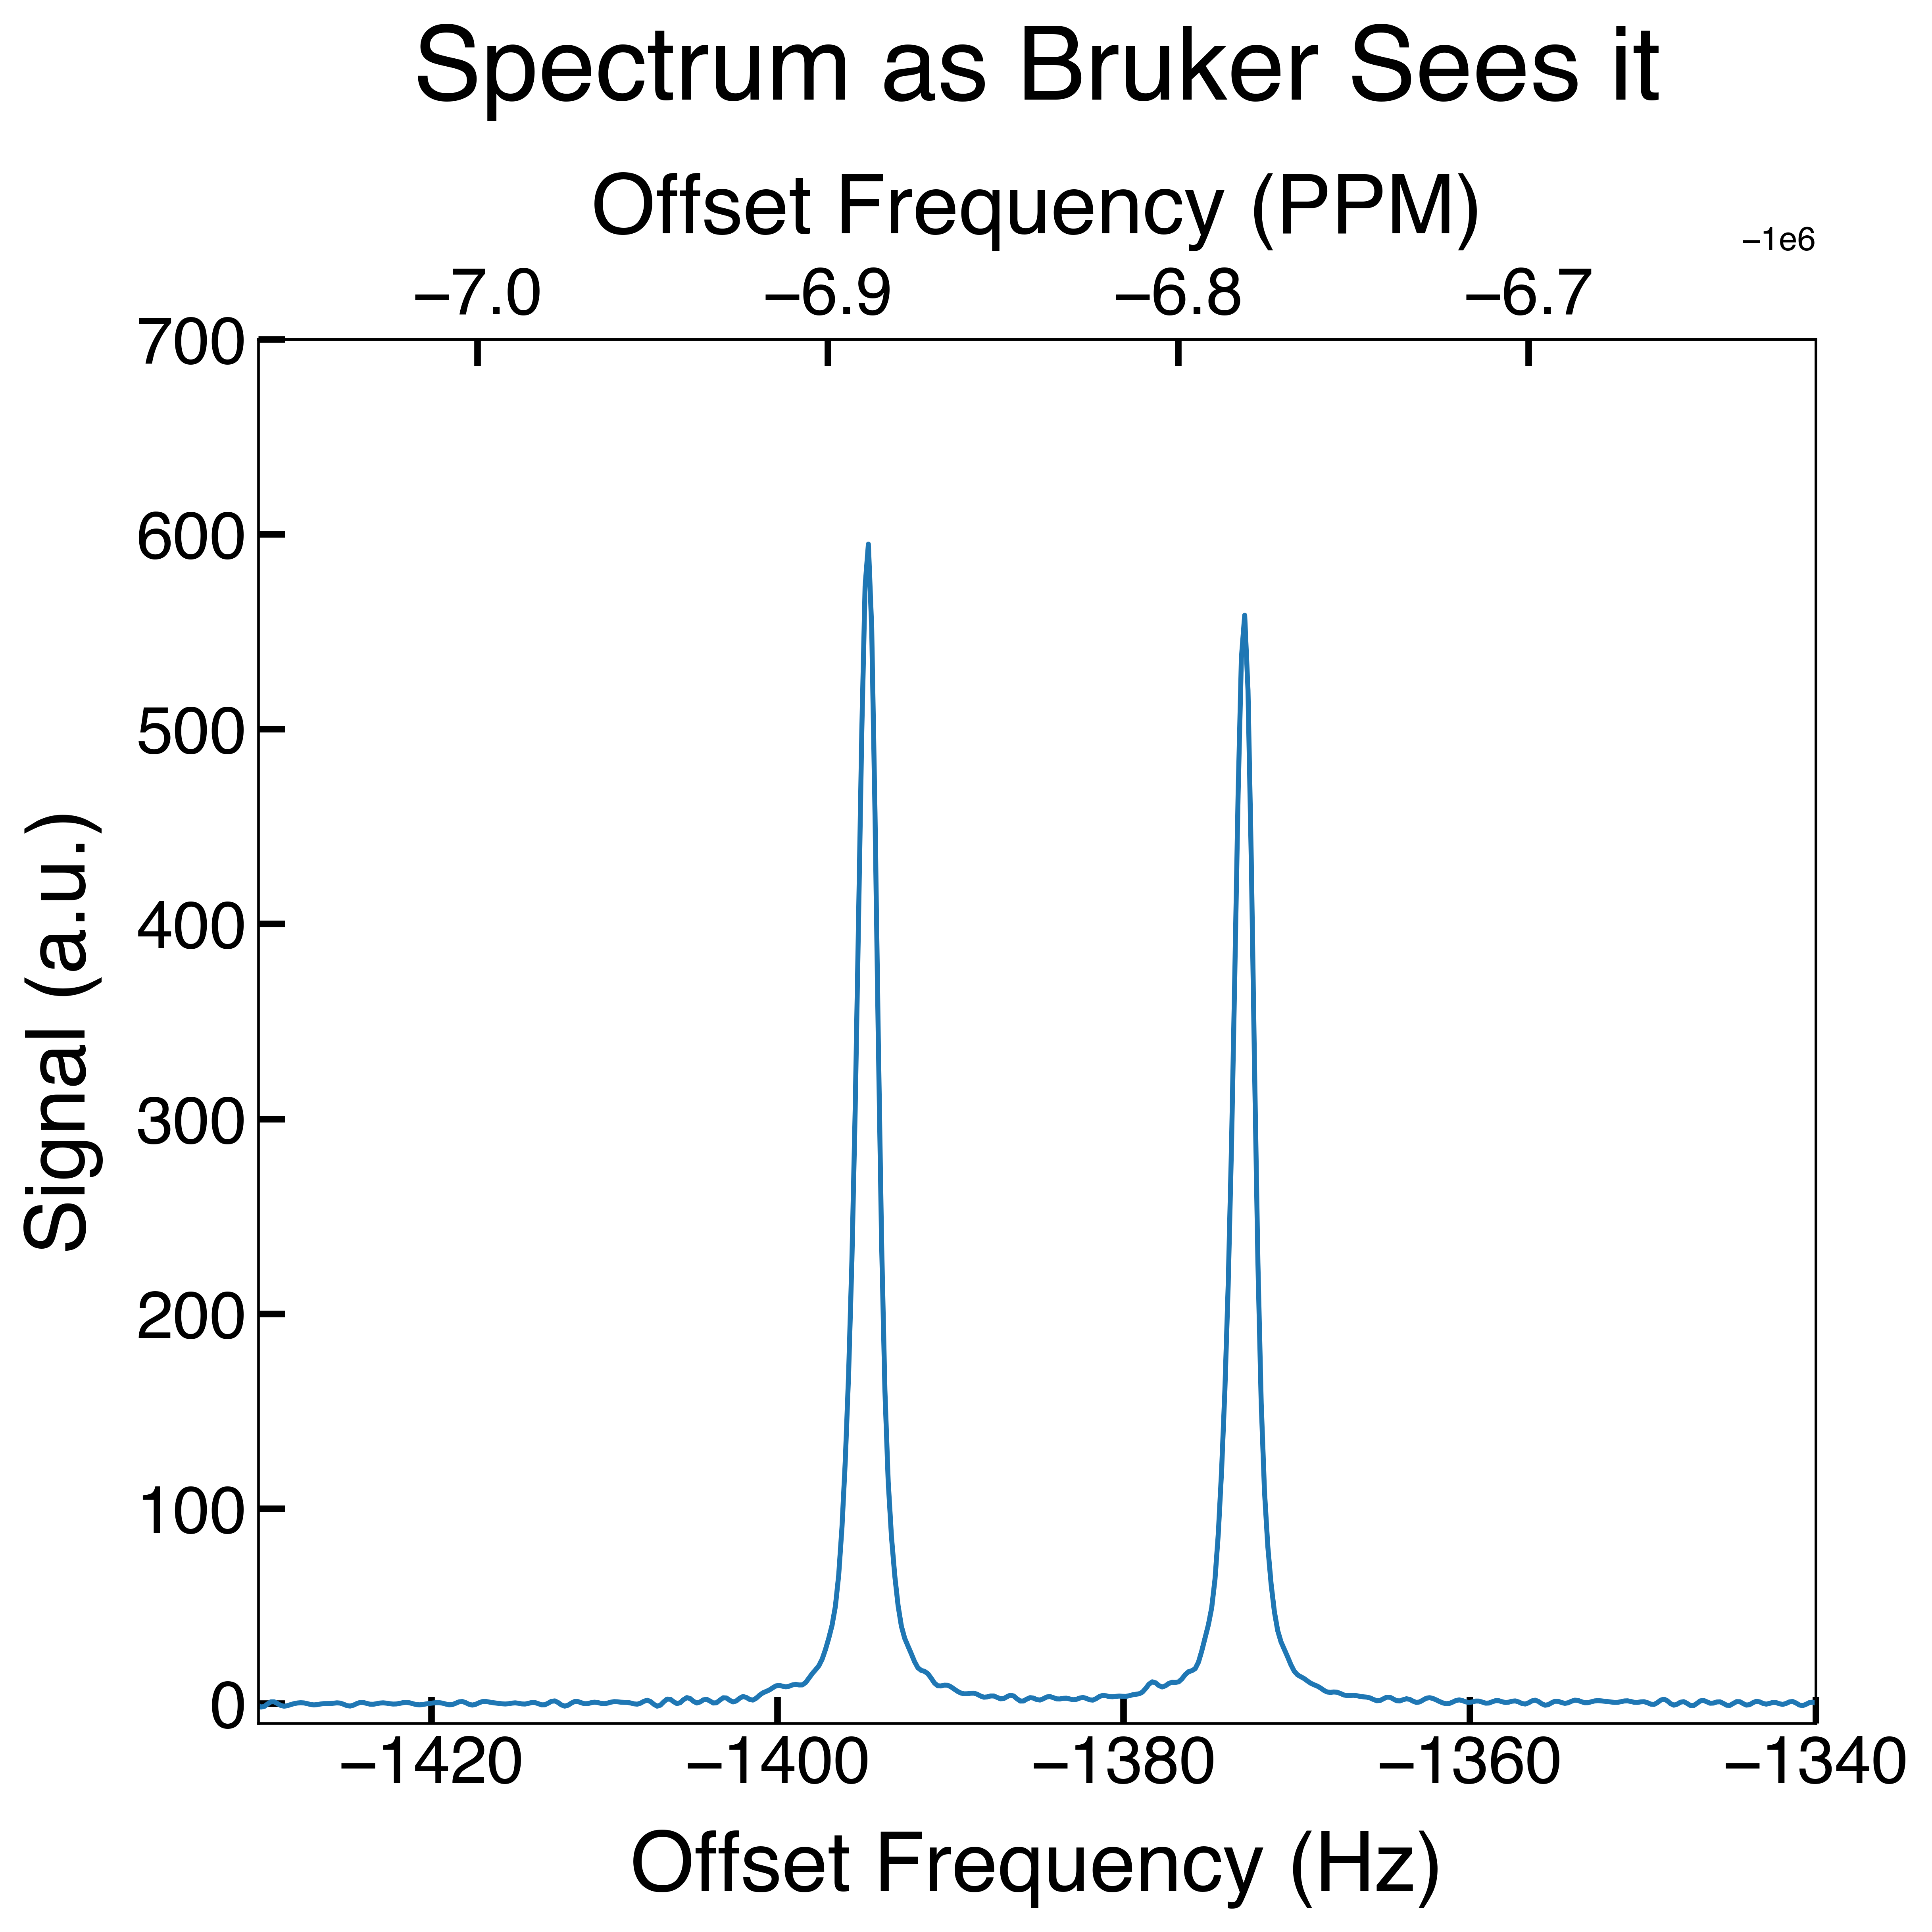

In [115]:
fig, ax = plt.subplots(constrained_layout=True)
mpl.rcParams['figure.dpi'] = 600

ax.plot(SF_centered_x_axis_recentered, real_spectrum / 10 ** 8 )
ax.set_xlabel('Offset Frequency (Hz)', size=25, labelpad=10)
ax.set_ylabel('Signal (a.u.)', size=25, labelpad=10)
ax.set_title('Spectrum as Bruker Sees it', size=31, pad=22)
secax = ax.secondary_xaxis('top', functions=(new_hz_to_ppm, new_ppm_to_hz))
secax.set_xlabel('Offset Frequency (PPM)', size=25, color='black', labelpad=10)

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.xaxis.label.set_color('black')

secax.tick_params(direction='in', axis='x', colors='black', labelsize=20)
ax.tick_params(direction='in', axis='x', colors='black', labelsize=20)
ax.tick_params(direction='in', axis='y', colors='black', labelsize=20)

#ax.fill_between(SF_centered_x_axis_recentered, real_spectrum/10**8, color='#334c80')
#ax.fill_between(SF_centered_x_axis_recentered, real_spectrum/10**8, where = SF_centered_x_axis_recentered>-1000, color='#759ebc') 


#plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0), useOffset=+2.4295e8)
ax.xaxis.get_offset_text().set_fontsize(16)
ax.xaxis.set_tick_params(size=8, width=2)
ax.yaxis.set_tick_params(size=8, width=2)
secax.xaxis.set_tick_params(size=8, width=2)
#Force the y-axis ticks to use 1e-9 as a base exponent 
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.1f')%(x*1e-8)))


plt.xlim(median(SF_centered_x_axis_recentered) + SWH / 2, median(SF_centered_x_axis_recentered) - SWH / 2)
plt.xlim(-1430, -1340)
plt.ylim(-10, 700)
fig.set_figheight(8)
fig.set_figwidth(8)
plt.savefig('ADP-Hard-doublet.pdf', format='pdf')
plt.show()

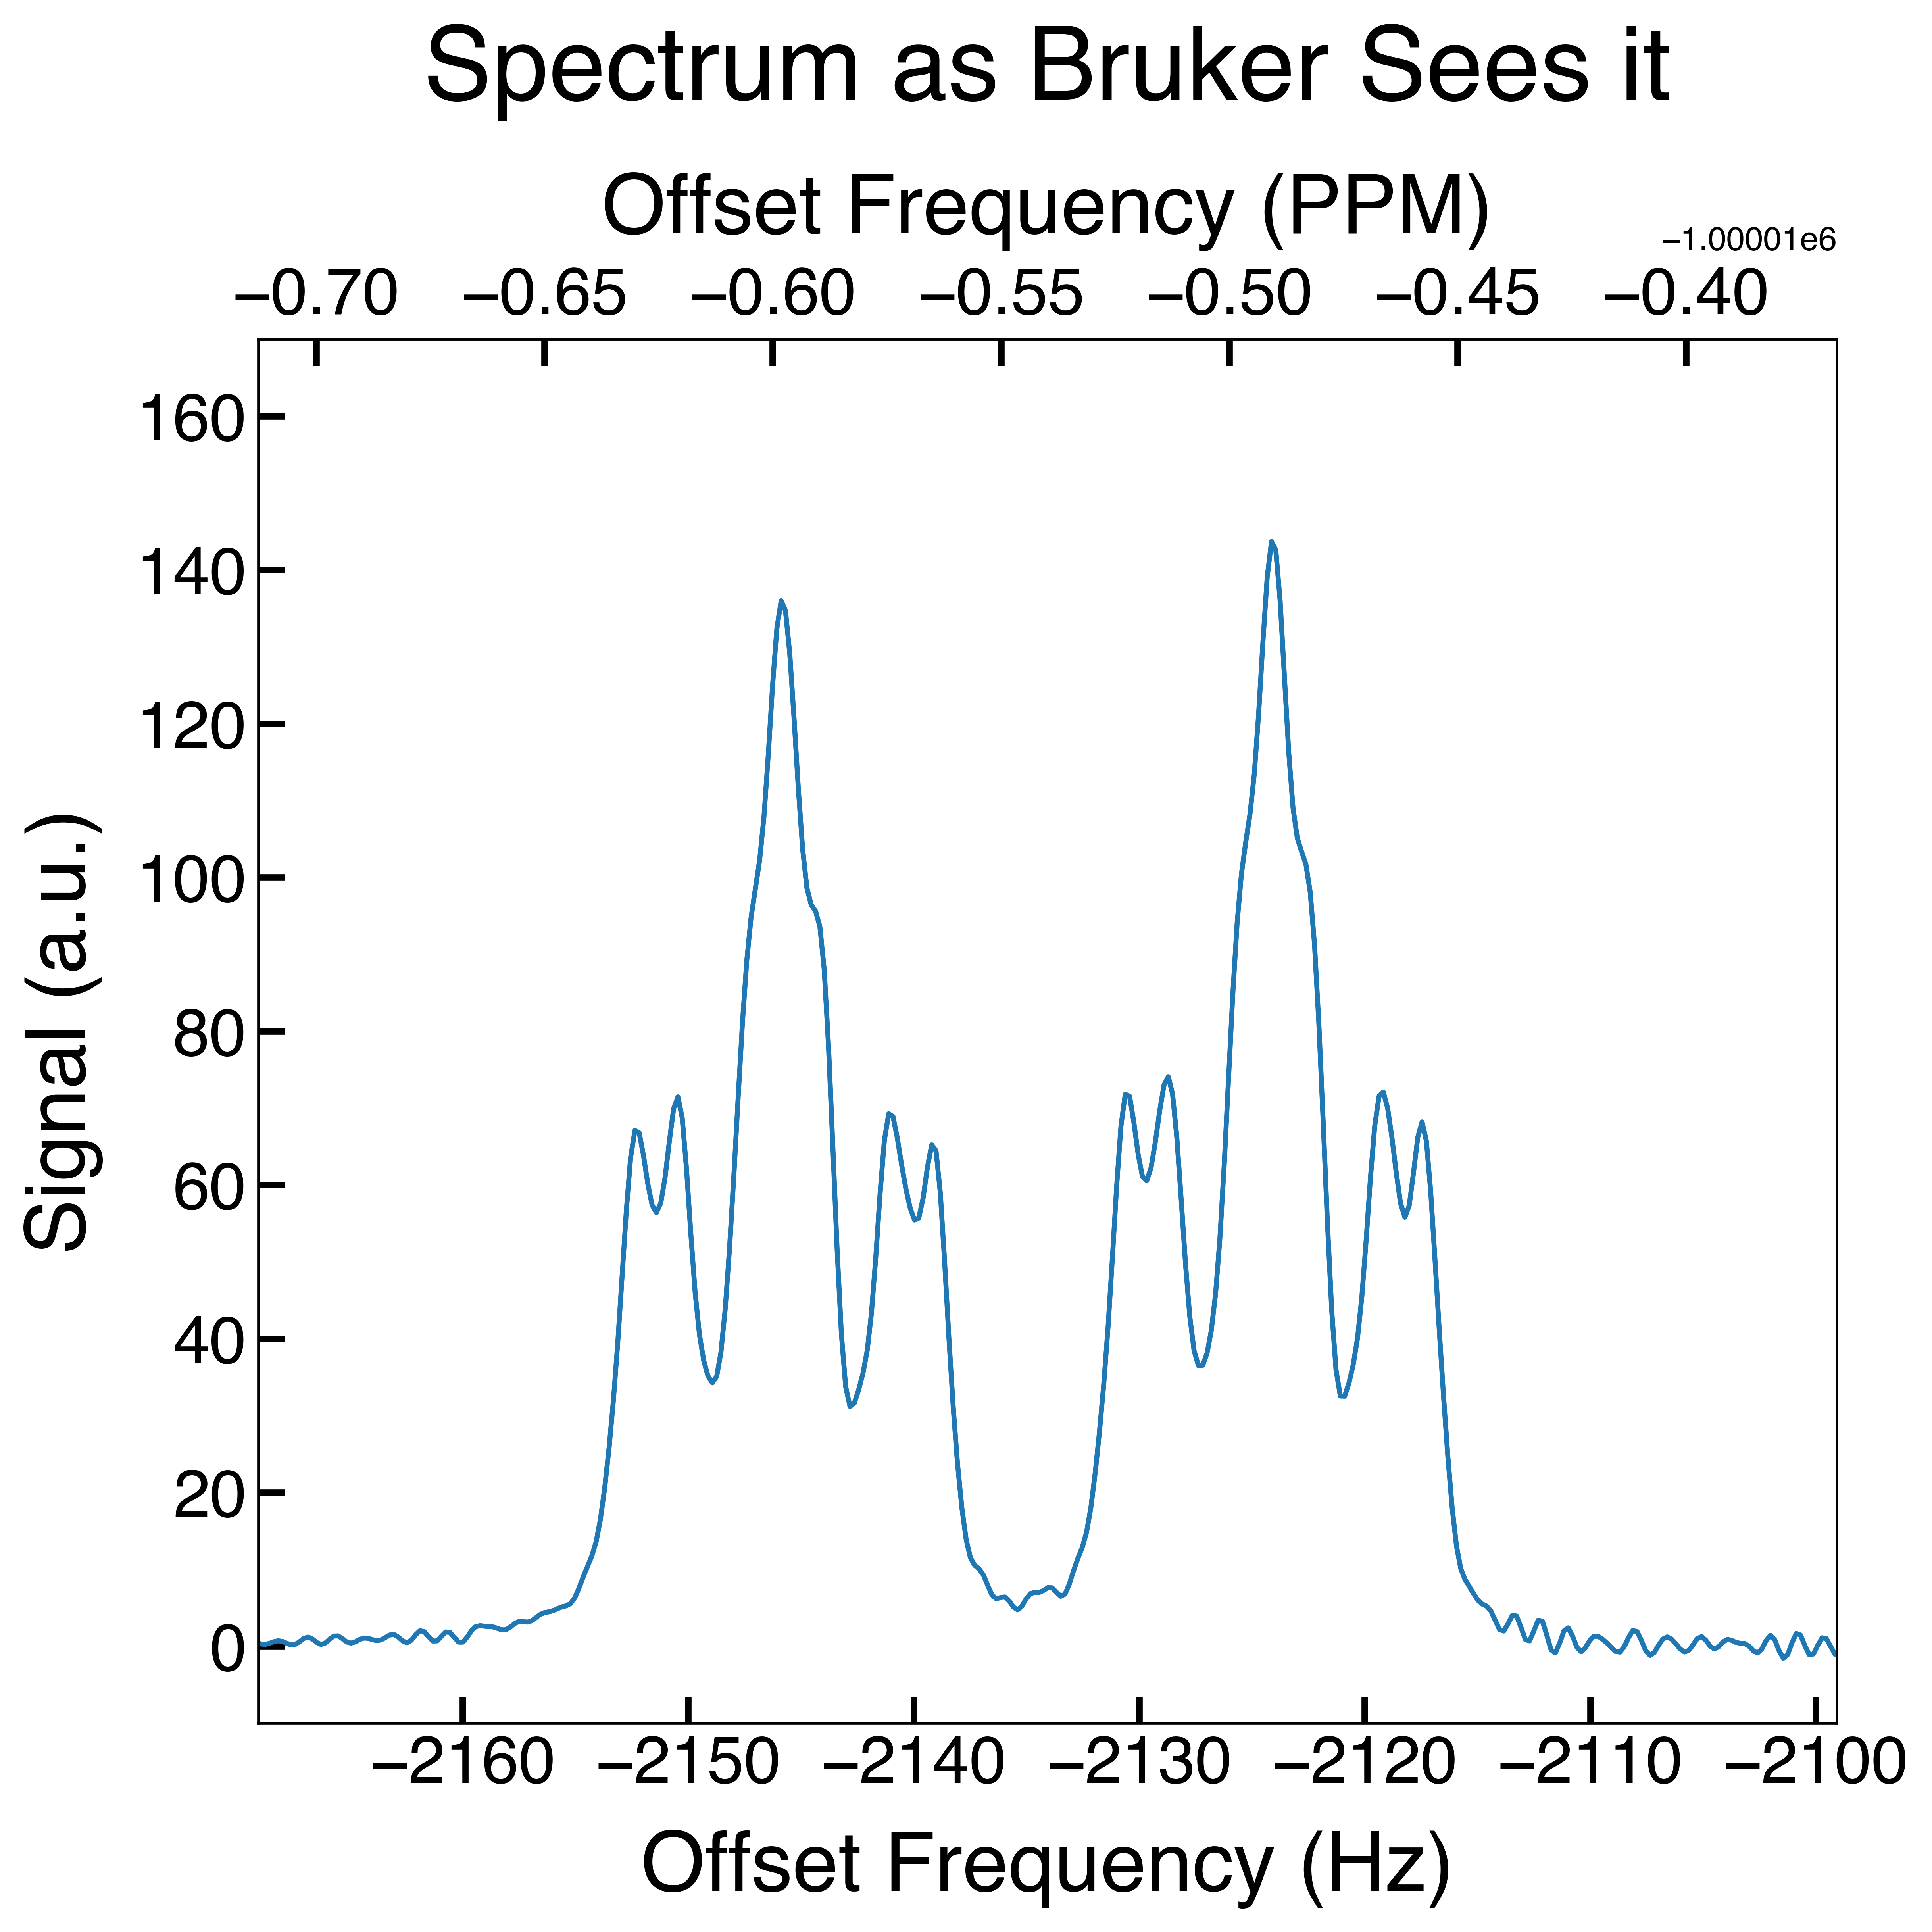

In [116]:
Q2=-2134.07

fig, ax = plt.subplots(constrained_layout=True)
mpl.rcParams['figure.dpi'] = 600

ax.plot(SF_centered_x_axis_recentered, real_spectrum / 10 ** 8 )
ax.set_xlabel('Offset Frequency (Hz)', size=25, labelpad=10)
ax.set_ylabel('Signal (a.u.)', size=25, labelpad=10)
ax.set_title('Spectrum as Bruker Sees it', size=31, pad=22)
secax = ax.secondary_xaxis('top', functions=(new_hz_to_ppm, new_ppm_to_hz))
secax.set_xlabel('Offset Frequency (PPM)', size=25, color='black', labelpad=10)

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.xaxis.label.set_color('black')

secax.tick_params(direction='in', axis='x', colors='black', labelsize=20)
ax.tick_params(direction='in', axis='x', colors='black', labelsize=20)
ax.tick_params(direction='in', axis='y', colors='black', labelsize=20)

#ax.fill_between(SF_centered_x_axis_recentered, real_spectrum/10**8, color='#334c80')
#ax.fill_between(SF_centered_x_axis_recentered, real_spectrum/10**8, where = SF_centered_x_axis_recentered>-1000, color='#759ebc') 


#plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0), useOffset=+2.4295e8)
ax.xaxis.get_offset_text().set_fontsize(16)
ax.xaxis.set_tick_params(size=8, width=2)
ax.yaxis.set_tick_params(size=8, width=2)
secax.xaxis.set_tick_params(size=8, width=2)
#Force the y-axis ticks to use 1e-9 as a base exponent 
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.1f')%(x*1e-8)))


plt.xlim(median(SF_centered_x_axis_recentered) + SWH / 2, median(SF_centered_x_axis_recentered) - SWH / 2)
plt.xlim(Q2-35,Q2+35)
plt.ylim(-10, 170)
fig.set_figheight(8)
fig.set_figwidth(8)
plt.savefig('ADP-BRUKER-DOUBLET_of_triplets.pdf', format='pdf')
plt.show()

In [117]:
Q2_dark ='#815509'
Q2_light='#DD935A'
Q1_light="#479FC1"
Q1_dark ='#0C6178'

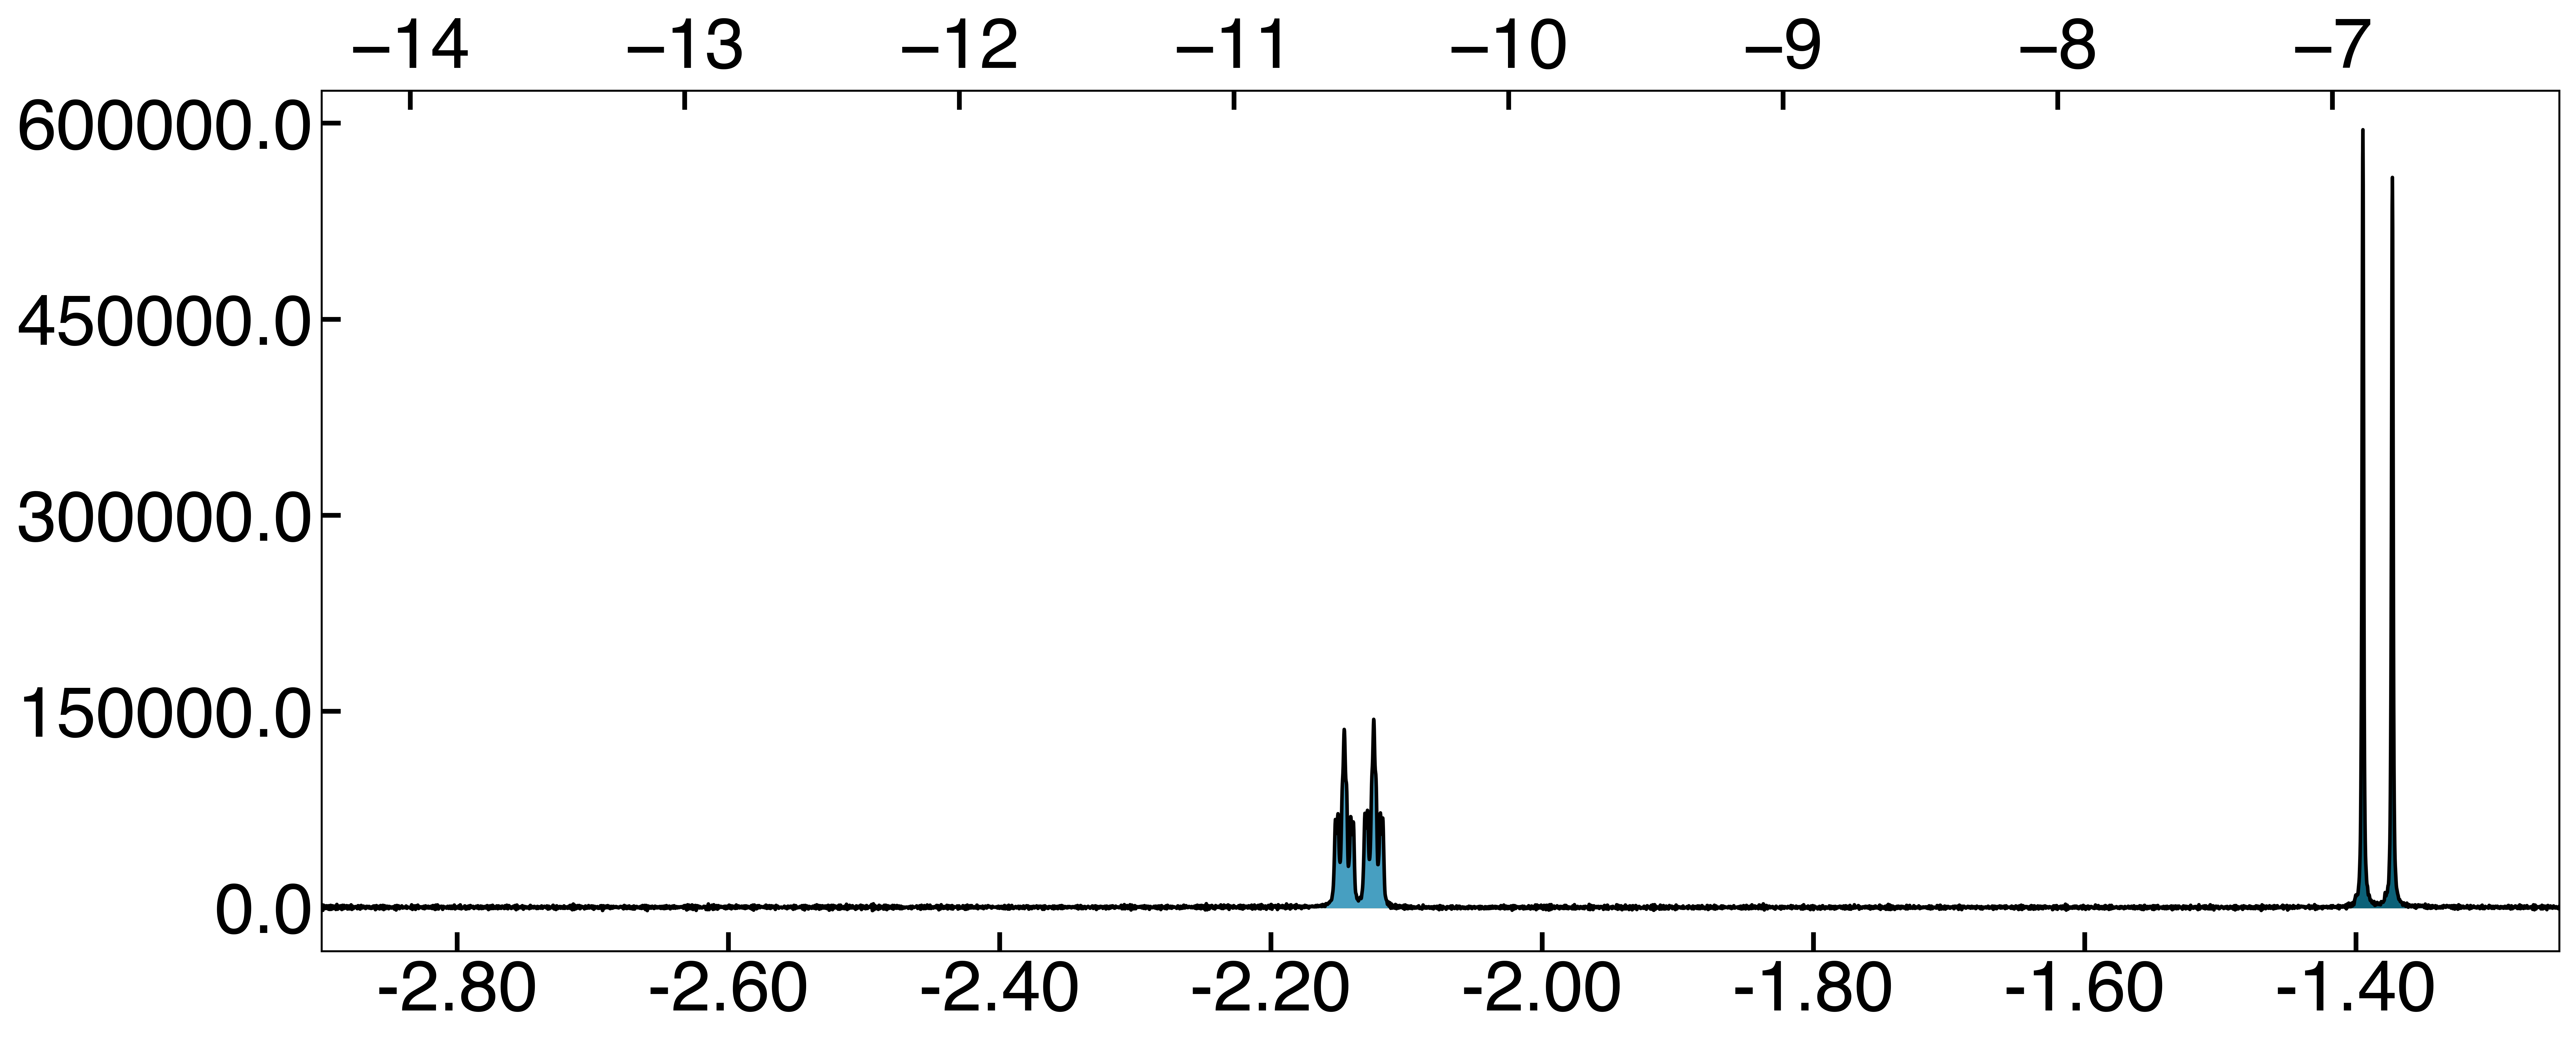

In [118]:
fig, ax = plt.subplots(constrained_layout=True)
mpl.rcParams['figure.dpi'] = 600
left_bound=-1250 #left bound offset in Hz
right_bound=-2900 #right bound offset in Hz
label_value=30

# Plot the primary data
ax.plot(BF1_centered_x_axis_recentered,  real_spectrum / 10 ** 8, color='black')

# Set limits for the primary axis
plt.xlim(left_bound, right_bound)

# Create the secondary x-axis using twiny()
secax = ax.twiny()

# Set secondary axis ticks and limits based on a transformation (PPM)
secax.set_xlim(new_hz_to_ppm(BF1+left_bound), new_hz_to_ppm(BF1+right_bound))
#secax.set_xlabel('Chemical Shift (PPM)', size=25)

# Remove scientific notation from the secondary x-axis
secax.xaxis.get_major_formatter().set_scientific(False)
secax.xaxis.set_tick_params(size=8, width=2)

# Customize tick parameters for both axes
secax.tick_params(direction='in', axis='x', colors='black', labelsize=label_value)
ax.tick_params(direction='in', axis='x', colors='black', labelsize=label_value)
ax.tick_params(direction='in', axis='y', colors='black', labelsize=label_value)

# Customize the appearance of the plot
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.xaxis.label.set_color('black')

# Fill between the plotted data for visualization
ax.fill_between(BF1_centered_x_axis_recentered, [val / 10 ** 8 for val in real_spectrum], color=Q2_dark)
ax.fill_between(BF1_centered_x_axis_recentered, [val / 10 ** 8 for val in real_spectrum], where=[x > -2541 for x in BF1_centered_x_axis_recentered], color=Q2_light)  # light blue
ax.fill_between(BF1_centered_x_axis_recentered, [val / 10 ** 8 for val in real_spectrum], where=[x > -2200 for x in BF1_centered_x_axis_recentered], color=Q1_light)  # light red
ax.fill_between(BF1_centered_x_axis_recentered, [val / 10 ** 8 for val in real_spectrum], where=[x > -1609  for x in BF1_centered_x_axis_recentered], color=Q1_dark)  # dark red

# Primary axis formatting
ax.xaxis.get_offset_text().set_fontsize(label_value)
ax.xaxis.set_tick_params(size=8, width=2)
ax.yaxis.set_tick_params(size=8, width=2)

# Format the x-axis labels in plain format (no scientific notation) on the primary axis
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: ('%.2f') % (x * 1e-3)))


# Format the y-axis labels in plain format (no scientific notation) on the primary axis
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: ('%.1f') % (x*1000)))
ax.yaxis.set_major_locator(MaxNLocator(5))

# Set figure dimensions and save the plot
fig.set_figheight(6)
fig.set_figwidth(15)
plt.savefig('ADP-DOUBLET-2.pdf', format='pdf')
ax.invert_xaxis() #flips bottom x axis to be on physics graphing standard
secax.invert_xaxis() #flips top x axis to be on physics graphing standard
plt.show()


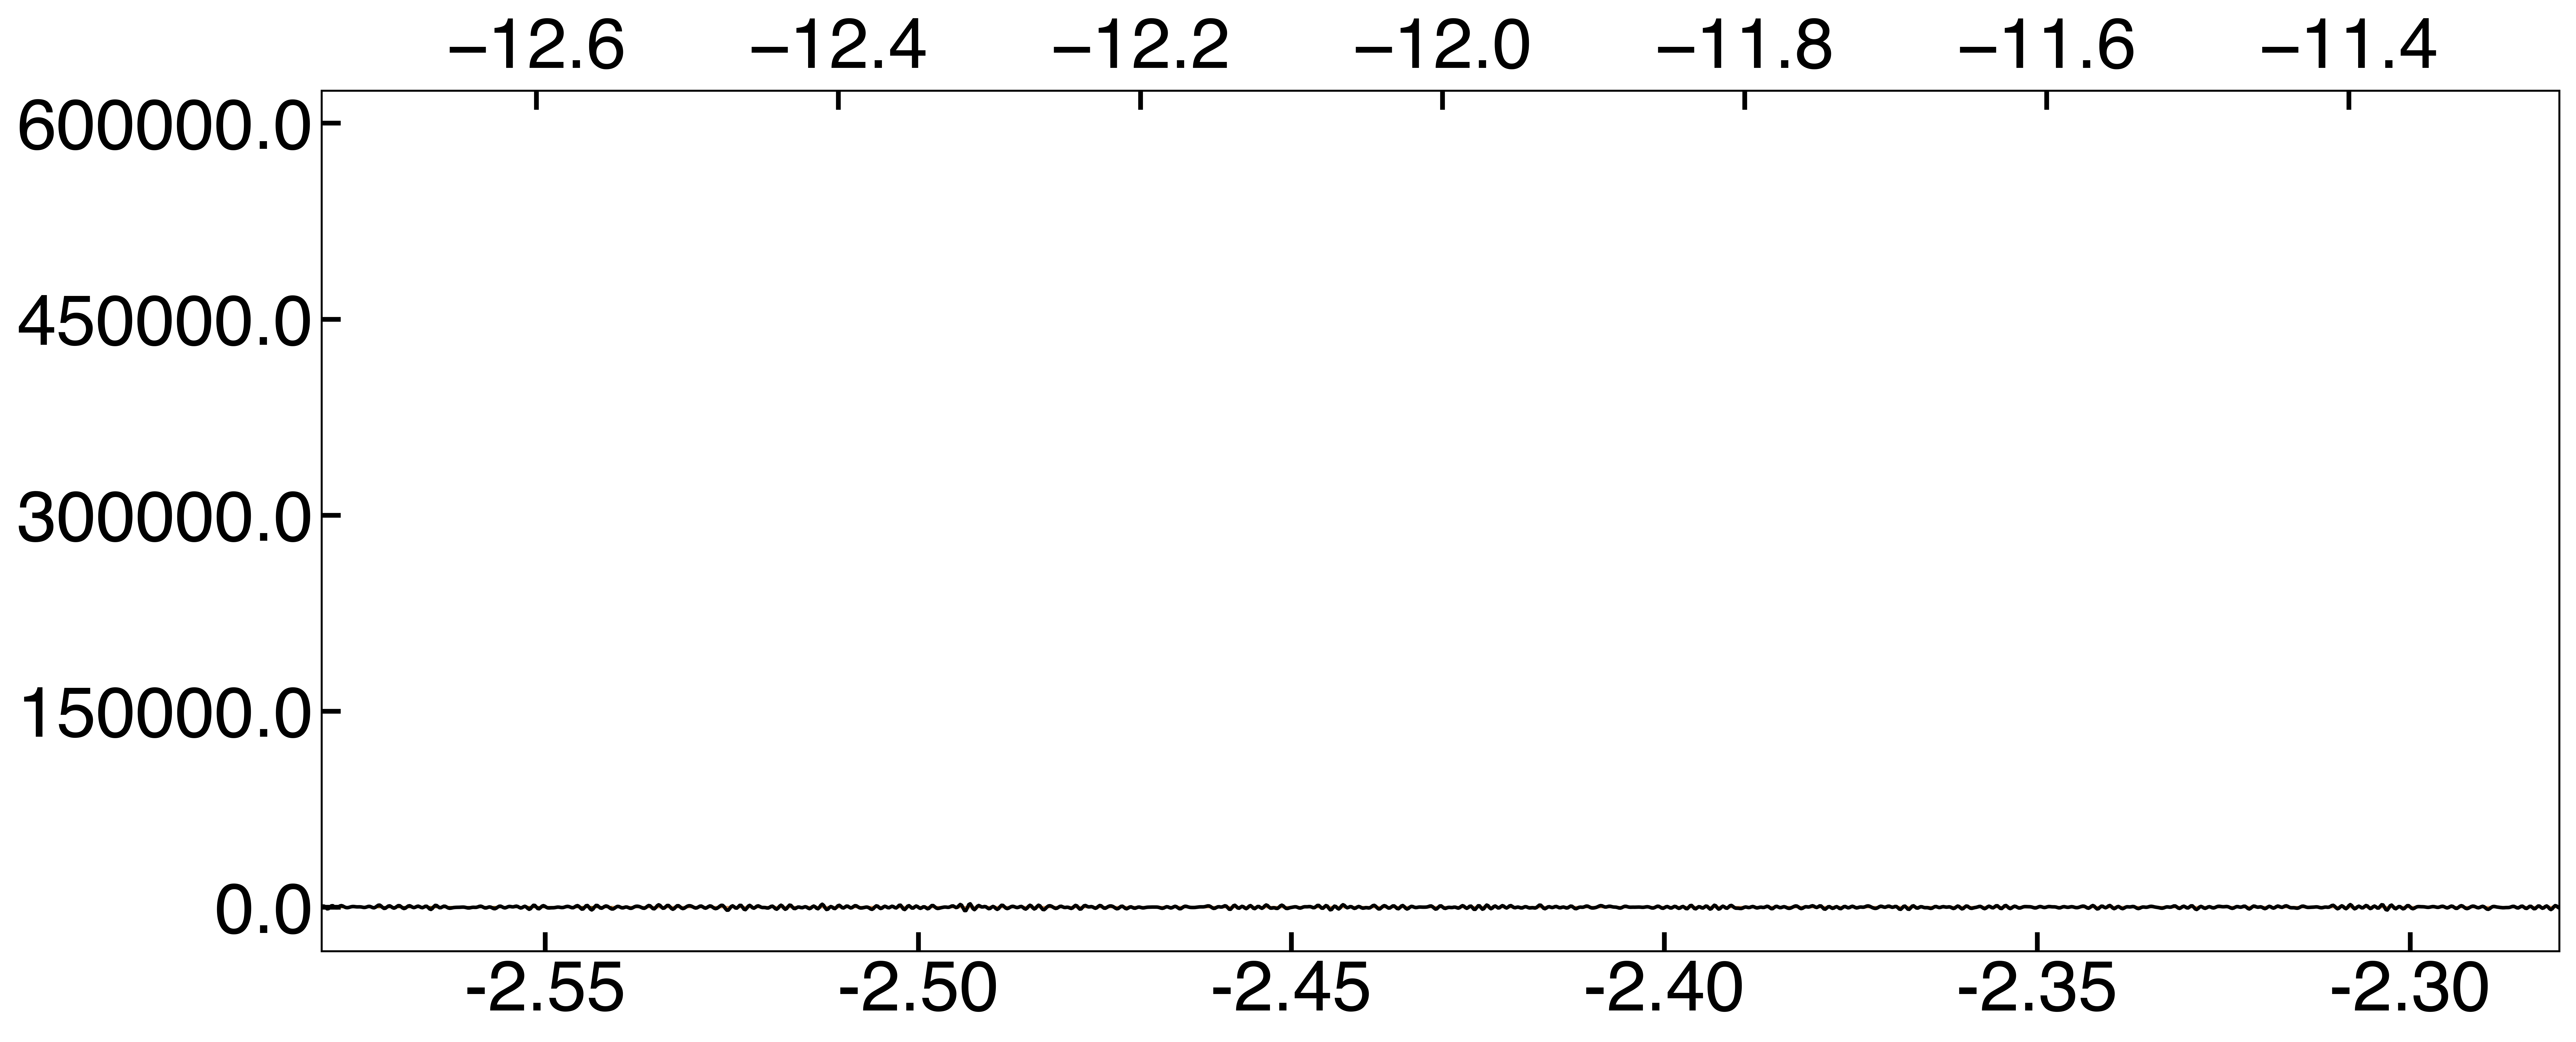

In [119]:
fig, ax = plt.subplots(constrained_layout=True)
mpl.rcParams['figure.dpi'] = 600
left_bound=-2280 #left bound offset in Hz
right_bound=-2580 #right bound offset in Hz
label_value=30
# Plot the primary data
ax.plot(BF1_centered_x_axis_recentered,  real_spectrum / 10 ** 8, color='black')

# Set limits for the primary axis
plt.xlim(left_bound, right_bound)

# Create the secondary x-axis using twiny()
secax = ax.twiny()

# Set secondary axis ticks and limits based on a transformation (PPM)
secax.set_xlim(new_hz_to_ppm(BF1+left_bound), new_hz_to_ppm(BF1+right_bound))
#secax.set_xlabel('Chemical Shift (PPM)', size=25)

# Remove scientific notation from the secondary x-axis
secax.xaxis.get_major_formatter().set_scientific(False)
secax.xaxis.set_tick_params(size=8, width=2)

# Customize tick parameters for both axes
secax.tick_params(direction='in', axis='x', colors='black', labelsize=label_value)
ax.tick_params(direction='in', axis='x', colors='black', labelsize=label_value)
ax.tick_params(direction='in', axis='y', colors='black', labelsize=label_value)

# Customize the appearance of the plot
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.xaxis.label.set_color('black')

# Fill between the plotted data for visualization
ax.fill_between(BF1_centered_x_axis_recentered, [val / 10 ** 8 for val in real_spectrum], color=Q2_dark)
ax.fill_between(BF1_centered_x_axis_recentered, [val / 10 ** 8 for val in real_spectrum], where=[x > -2541 for x in BF1_centered_x_axis_recentered], color=Q2_light)  # light blue
ax.fill_between(BF1_centered_x_axis_recentered, [val / 10 ** 8 for val in real_spectrum], where=[x > -2200 for x in BF1_centered_x_axis_recentered], color=Q1_light)  # light red
ax.fill_between(BF1_centered_x_axis_recentered, [val / 10 ** 8 for val in real_spectrum], where=[x > -1609  for x in BF1_centered_x_axis_recentered], color=Q1_dark)  # dark red

# Primary axis formatting
ax.xaxis.get_offset_text().set_fontsize(label_value)
ax.xaxis.set_tick_params(size=8, width=2)
ax.yaxis.set_tick_params(size=8, width=2)

# Format the x-axis labels in plain format (no scientific notation) on the primary axis
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: ('%.2f') % (x * 1e-3)))


# Format the y-axis labels in plain format (no scientific notation) on the primary axis
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: ('%.1f') % (x*1000)))
ax.yaxis.set_major_locator(MaxNLocator(5))

# Set figure dimensions and save the plot
fig.set_figheight(6)
fig.set_figwidth(15)
ax.invert_xaxis() #flips bottom x axis to be on physics graphing standard
secax.invert_xaxis() #flips top x axis to be on physics graphing standard
plt.savefig('ADP-DOUBLET-Q2.pdf', format='pdf')
plt.show()


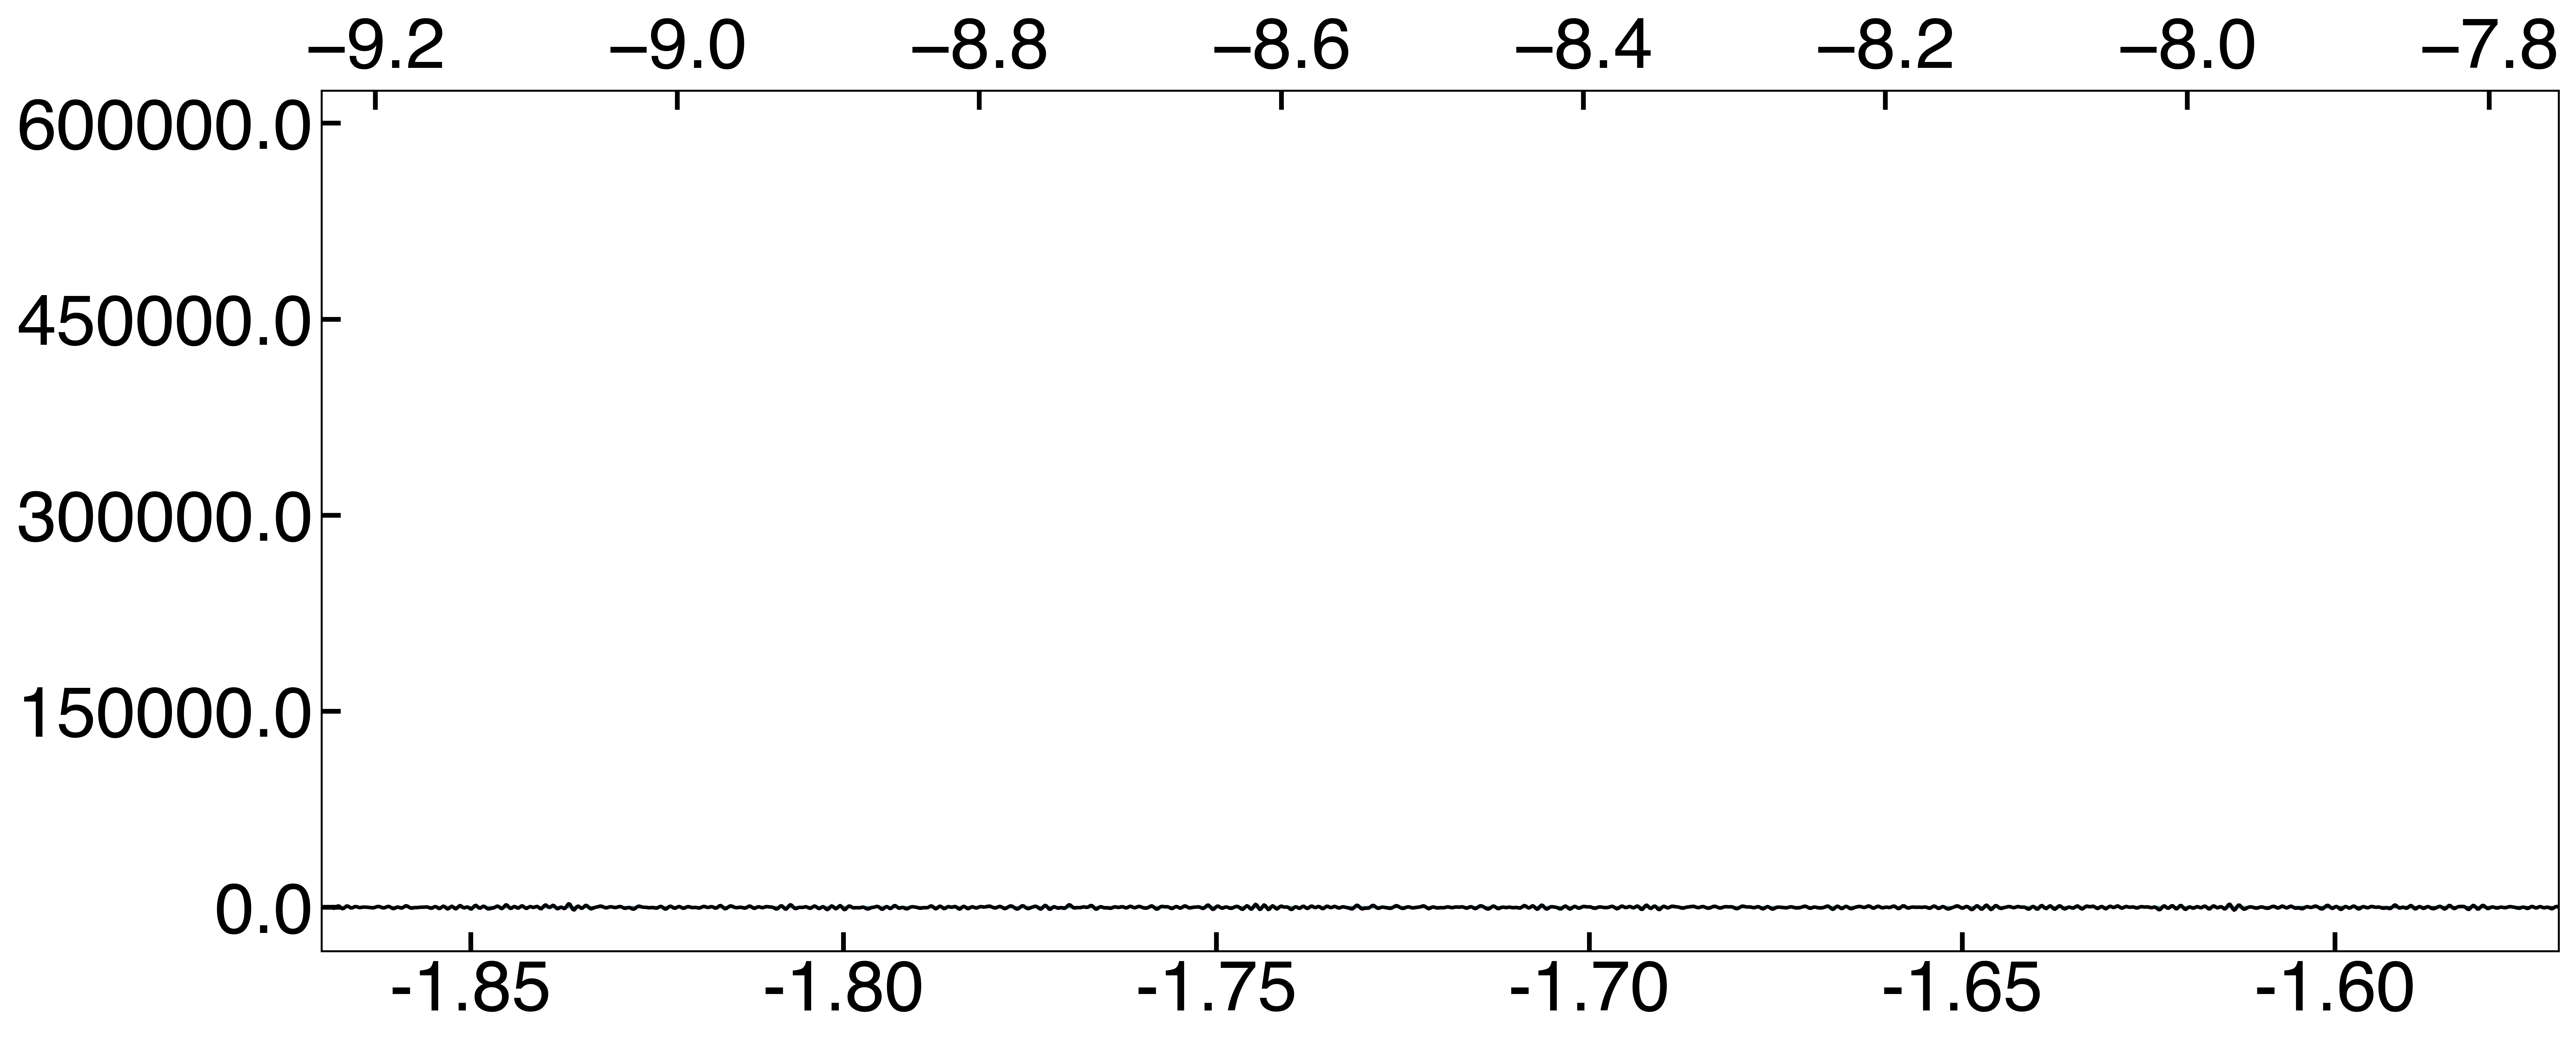

In [120]:
fig, ax = plt.subplots(constrained_layout=True)
mpl.rcParams['figure.dpi'] = 600
left_bound=-1570 #left bound offset in Hz
right_bound=-1870 #right bound offset in Hz
label_value=30

# Plot the primary data
ax.plot(BF1_centered_x_axis_recentered,  real_spectrum / 10 ** 8, color='black')

# Set limits for the primary axis
plt.xlim(left_bound, right_bound)

# Create the secondary x-axis using twiny()
secax = ax.twiny()

# Set secondary axis ticks and limits based on a transformation (PPM)
secax.set_xlim(new_hz_to_ppm(BF1+left_bound), new_hz_to_ppm(BF1+right_bound))
#secax.set_xlabel('Chemical Shift (PPM)', size=25)

# Remove scientific notation from the secondary x-axis
secax.xaxis.get_major_formatter().set_scientific(False)
secax.xaxis.set_tick_params(size=8, width=2)

# Customize tick parameters for both axes
secax.tick_params(direction='in', axis='x', colors='black', labelsize=label_value)
ax.tick_params(direction='in', axis='x', colors='black', labelsize=label_value)
ax.tick_params(direction='in', axis='y', colors='black', labelsize=label_value)

# Customize the appearance of the plot
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.xaxis.label.set_color('black')

# Fill between the plotted data for visualization
ax.fill_between(BF1_centered_x_axis_recentered, [val / 10 ** 8 for val in real_spectrum], color=Q2_dark)
ax.fill_between(BF1_centered_x_axis_recentered, [val / 10 ** 8 for val in real_spectrum], where=[x > -2541 for x in BF1_centered_x_axis_recentered], color=Q2_light)  # light blue
ax.fill_between(BF1_centered_x_axis_recentered, [val / 10 ** 8 for val in real_spectrum], where=[x > -2200 for x in BF1_centered_x_axis_recentered], color=Q1_light)  # light red
ax.fill_between(BF1_centered_x_axis_recentered, [val / 10 ** 8 for val in real_spectrum], where=[x > -1609  for x in BF1_centered_x_axis_recentered], color=Q1_dark)  # dark red

# Primary axis formatting
ax.xaxis.get_offset_text().set_fontsize(label_value)
ax.xaxis.set_tick_params(size=8, width=2)
ax.yaxis.set_tick_params(size=8, width=2)

# Format the x-axis labels in plain format (no scientific notation) on the primary axis
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: ('%.2f') % (x * 1e-3)))


# Format the y-axis labels in plain format (no scientific notation) on the primary axis
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: ('%.1f') % (x*1000)))
ax.yaxis.set_major_locator(MaxNLocator(5))



# Set figure dimensions and save the plot
fig.set_figheight(6)
fig.set_figwidth(15)
ax.invert_xaxis() #flips bottom x axis to be on physics graphing standard
secax.invert_xaxis() #flips top x axis to be on physics graphing standard
plt.savefig('ADP-DOUBLET-Q1.pdf', format='pdf')
plt.show()


In [121]:
###############################Graveyard###############################


"""
fig, ax = plt.subplots(constrained_layout=True)
mpl.rcParams['figure.dpi'] = 600

ax.plot(BF1_centered_x_axis_recentered, real_spectrum / 10 ** 8, color='black')
#ax.set_xlabel('Offset Frequency (Hz)', size=25, labelpad=10)
#ax.set_ylabel('Signal (a.u.)', size=25, labelpad=10)
#ax.set_title('Spectrum Paper Calibrated', size=31, pad=22)
secax = ax.secondary_xaxis('top', functions=(new_hz_to_ppm, new_ppm_to_hz), color='black')
#secax.set_xlabel('Offset Frequency (PPM)', size=25, color='black', labelpad=10)
secax.xaxis.get_major_formatter().set_scientific(False)

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.xaxis.label.set_color('black')

secax.tick_params(direction='in', axis='x', colors='black', labelsize=30)
ax.tick_params(direction='in', axis='x', colors='black', labelsize=30)
ax.tick_params(direction='in', axis='y', colors='black', labelsize=30)

ax.fill_between(BF1_centered_x_axis_recentered, real_spectrum / 10 ** 8, color='#334c80') #dark blue
ax.fill_between(BF1_centered_x_axis_recentered, real_spectrum / 10 ** 8, where=BF1_centered_x_axis_recentered < -2600, color='#759ebc') #llight blue
ax.fill_between(BF1_centered_x_axis_recentered, real_spectrum / 10 ** 8, where=BF1_centered_x_axis_recentered < -2650, color='#9c4629') #light red
ax.fill_between(BF1_centered_x_axis_recentered, real_spectrum / 10 ** 8, where=BF1_centered_x_axis_recentered < -2738, color='#6f1d20') #dark red

ax.fill_between(BF1_centered_x_axis_recentered, real_spectrum / 10 ** 8, where=BF1_centered_x_axis_recentered < -3500, color='#449d27') #light green

#plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0), useOffset=+2.4295e8)
ax.xaxis.get_offset_text().set_fontsize(16)
ax.xaxis.set_tick_params(size=8, width=2)
ax.yaxis.set_tick_params(size=8, width=2)
secax.xaxis.set_tick_params(size=8, width=2)
#Force the y-axis ticks to use 1e-9 as a base exponent 
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: ('%.1f')%(x*1e-3)))

plt.xlim(-2550, -3150)
#plt.xlim(-5400, -5800)
#plt.ylim(-.1 , 4)
fig.set_figheight(6)
fig.set_figwidth(15)
plt.savefig('ATP-DOUBLETS')
plt.show()
"""

"\nfig, ax = plt.subplots(constrained_layout=True)\nmpl.rcParams['figure.dpi'] = 600\n\nax.plot(BF1_centered_x_axis_recentered, real_spectrum / 10 ** 8, color='black')\n#ax.set_xlabel('Offset Frequency (Hz)', size=25, labelpad=10)\n#ax.set_ylabel('Signal (a.u.)', size=25, labelpad=10)\n#ax.set_title('Spectrum Paper Calibrated', size=31, pad=22)\nsecax = ax.secondary_xaxis('top', functions=(new_hz_to_ppm, new_ppm_to_hz), color='black')\n#secax.set_xlabel('Offset Frequency (PPM)', size=25, color='black', labelpad=10)\nsecax.xaxis.get_major_formatter().set_scientific(False)\n\nax.spines['top'].set_color('black')\nax.spines['bottom'].set_color('black')\nax.xaxis.label.set_color('black')\n\nsecax.tick_params(direction='in', axis='x', colors='black', labelsize=30)\nax.tick_params(direction='in', axis='x', colors='black', labelsize=30)\nax.tick_params(direction='in', axis='y', colors='black', labelsize=30)\n\nax.fill_between(BF1_centered_x_axis_recentered, real_spectrum / 10 ** 8, color='#334